In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
import Data_for_bp as dfb

In [2]:
df = pd.read_pickle('Data for Practicum 2/ticks_2019.pkl')

In [3]:
time_deltas = df.index.to_series().diff()

In [4]:
def tick_data_describe(df):
    time_deltas = df.index.to_series().diff()
    summary_data = {
        'Description': [
            'Number of ticks',
            'Mean time between ticks',
            'Median time between ticks',
            'Max time between ticks',
            'Min time between ticks',
            'Ticks with time delta > 10 minutes',
            'Ticks with time delta > 60 seconds',
            'Ticks with time delta > 1 second',
            'Ticks with time delta > 0.1 seconds',
            'Ticks with time delta < 0.1 seconds'
        ],
        'Value': [
            len(df),
            time_deltas.mean(),
            time_deltas.median(),
            time_deltas.max(),
            time_deltas.min(),
            len(time_deltas[time_deltas > pd.Timedelta(minutes=10)]),
            len(time_deltas[time_deltas > pd.Timedelta(seconds=60)]),
            len(time_deltas[time_deltas > pd.Timedelta(seconds=1)]),
            len(time_deltas[time_deltas > pd.Timedelta(seconds=0.1)]),
            len(time_deltas[time_deltas < pd.Timedelta(seconds=0.1)])
        ]
    }

    summary_df = pd.DataFrame(summary_data)
    fig, ax = plt.subplots(figsize=(10, 3))  # set the size
    ax.axis('off')
    ax.table(cellText=summary_df.values, colLabels=summary_df.columns, cellLoc = 'center',loc='center')
    plt.show()


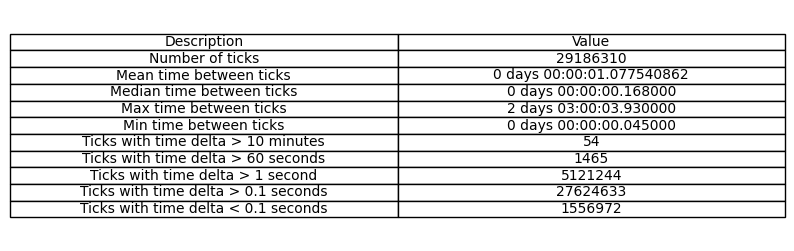

In [5]:
tick_data_describe(df)

In [6]:
ohlc = dfb.tick_to_ohlc(df, '1D')

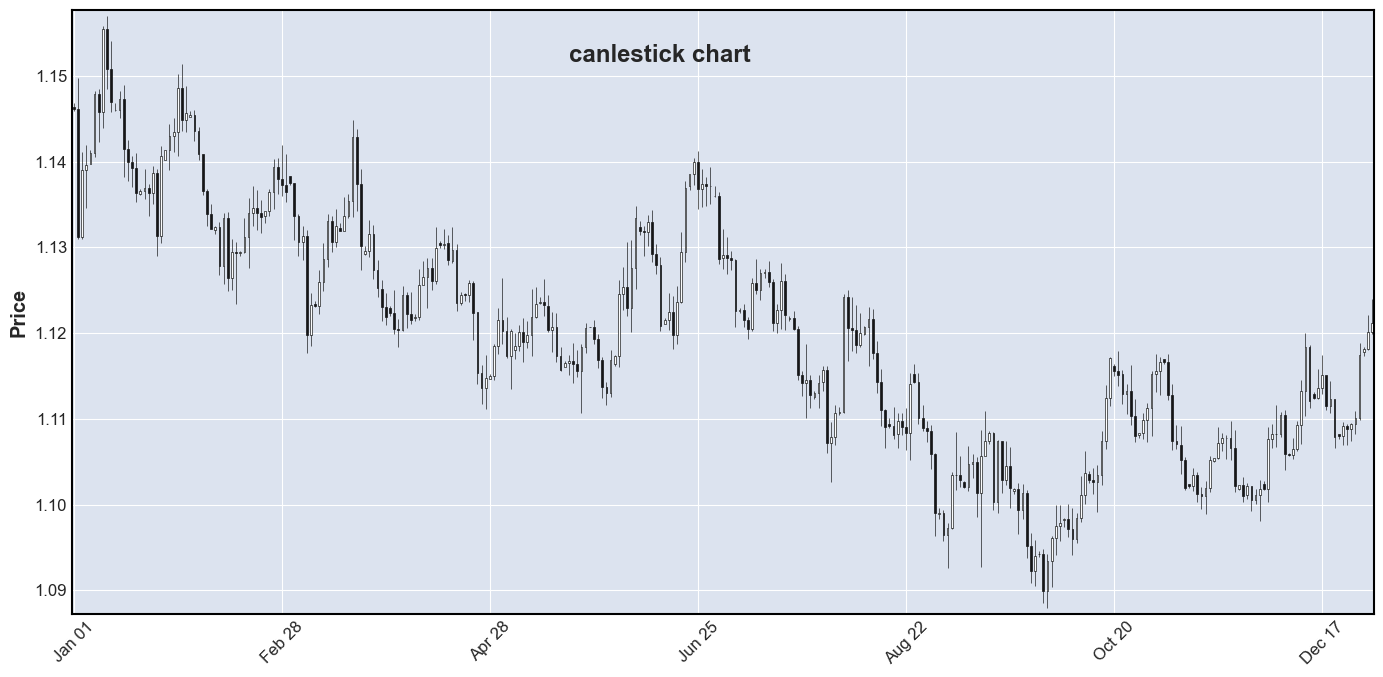

In [7]:
dfb.plot_data(ohlc)

In [8]:
def ohlc_stats(ohlc):
    ohlc['returns'] = ohlc['close'].pct_change()
    ohlc['daily_returns'] = (ohlc['close']-ohlc['open'])/ohlc['open']
    daily_volatility = ohlc['returns'].std()
    buy_and_hold_return = (ohlc['returns']+1).prod()
    mean_return = ohlc['returns'].mean()
    

In [9]:
def ohlc_stats(ohlc):
    ohlc['returns'] = ohlc['close'].pct_change()
    ohlc['daily_returns'] = (ohlc['close']-ohlc['open'])/ohlc['open']
    fig,axs = plt.subplots(3,1,figsize=(10,10))
    axs[0].plot(ohlc['returns'])
    axs[1].hist(ohlc['returns'],bins=20)

    daily_volatility = ohlc['returns'].std()*np.sqrt(252)*100
    buy_and_hold_return = ((ohlc['returns']+1).prod() - 1)*100  # Adjusting to get the total return
    mean_return = ohlc['returns'].mean()*100

    stats_data = {
        'Description': [
            'Daily Volatility',
            'Buy and Hold Return',
            'Mean Return'
        ],
        'Value': [
            daily_volatility,
            buy_and_hold_return,
            mean_return
        ]
    }
    
    stats_df = pd.DataFrame(stats_data)
    axs[2].axis('off')
    axs[2].table(cellText=stats_df.values, colLabels=stats_df.columns, cellLoc = 'center',loc='center')
    fig.tight_layout()
    plt.show()


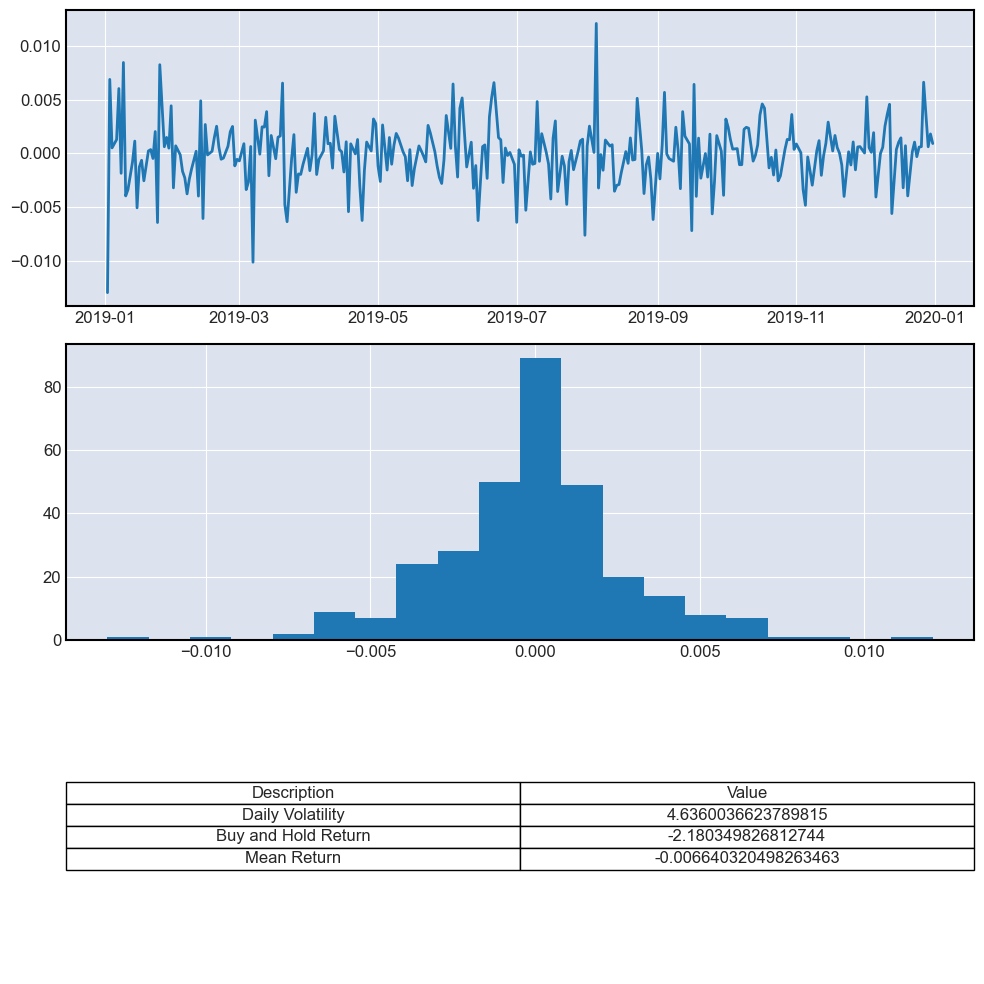

In [10]:
ohlc_stats(ohlc)

In [11]:
def data_analysis_for_bp(tick_data_file):
    df = pd.read_pickle(tick_data_file)
    tick_data_describe(df)
    ohlc = dfb.tick_to_ohlc(df, '1D')
    dfb.plot_data(ohlc)
    ohlc_stats(ohlc)

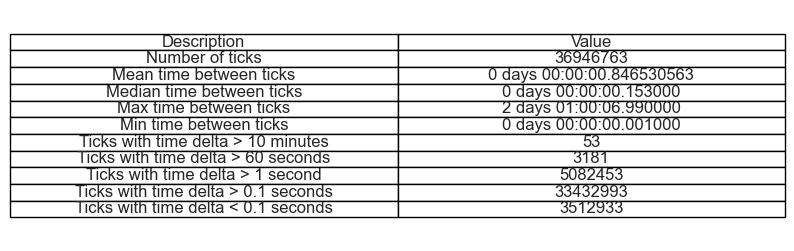

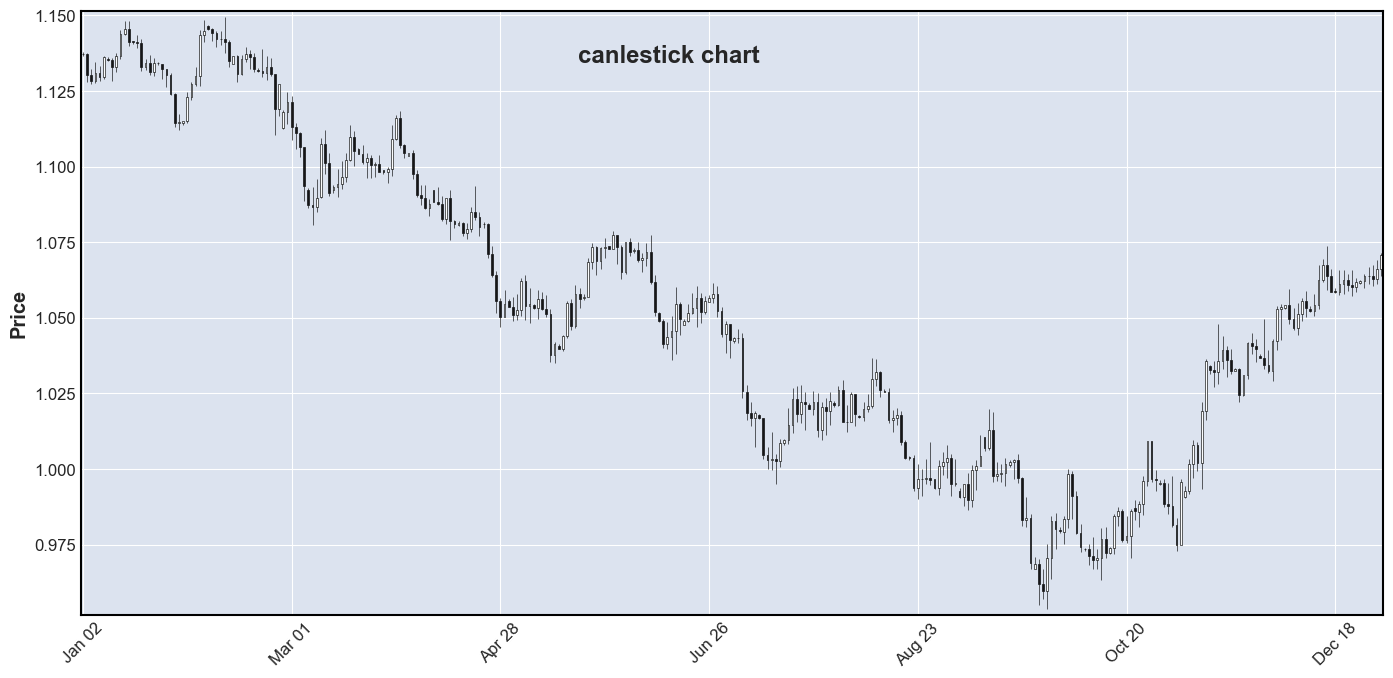

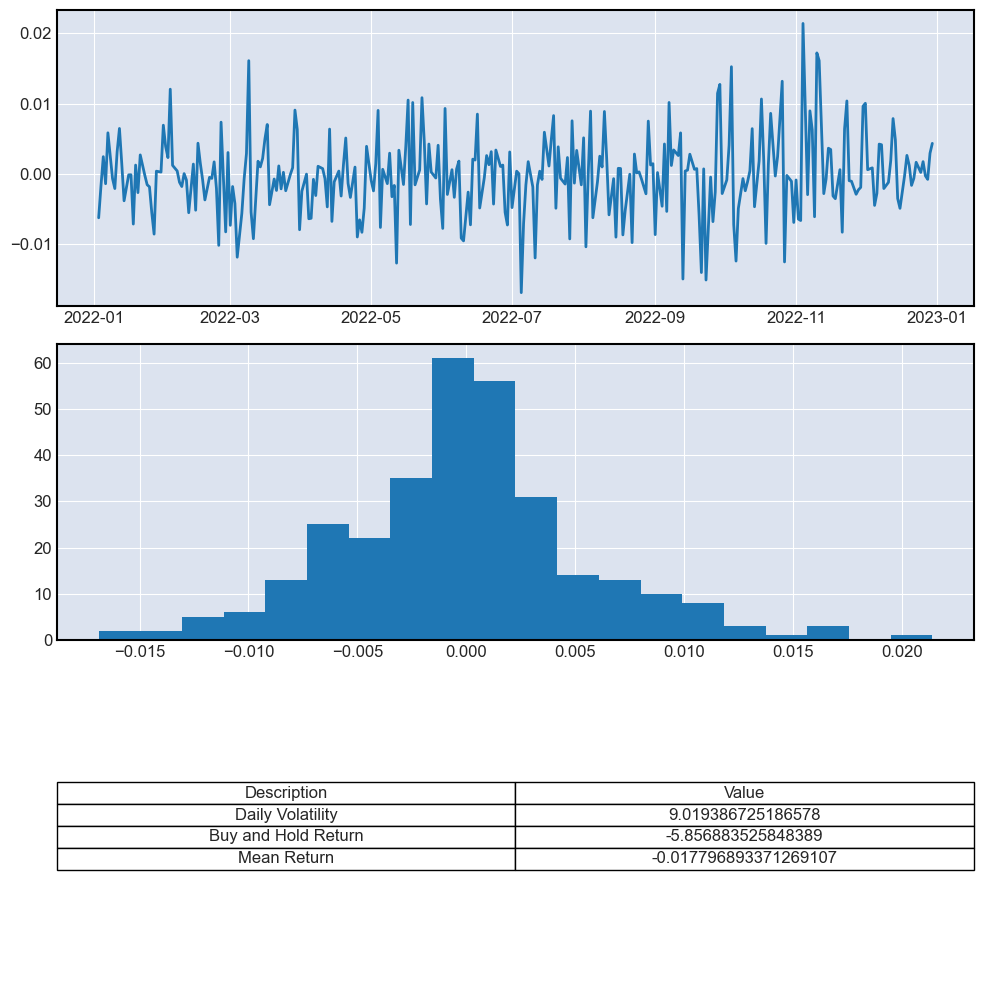

In [12]:
data_analysis_for_bp('Data for Practicum 2/ticks_2022.pkl')

## Ladder strategy data engineering and strategy visualisation

In [13]:
def ladderize_open(tick_data, grid_size):
    """
    Convert tick data into step-based data using a specified grid size.

    :param tick_data: A pandas Series of tick data.
    :param grid_size: The size of the grid to discretize the tick data.
    :return: A pandas Series of ladderized data.
    """
    ladderized_data = [tick_data.iloc[0]]
    for i in range(1, len(tick_data)):
        if tick_data.iloc[i] > ladderized_data[-1] + grid_size:
            ladderized_data.append(ladderized_data[-1] + grid_size)
        elif tick_data.iloc[i] < ladderized_data[-1] - grid_size:
            ladderized_data.append(ladderized_data[-1] - grid_size)
        else:
            ladderized_data.append(ladderized_data[-1])
    # Adding the final close price
    ladderized_data[-1]=tick_data.iloc[-1]
    return pd.Series(np.round(ladderized_data,4), index=tick_data.index)

In [14]:
def ladderize_absolute(tick_data, grid_size):
    """
    Convert tick data into step-based data using a specified grid size.

    :param tick_data: A pandas Series of tick data.
    :param grid_size: The size of the grid to discretize the tick data.
    :return: A pandas Series of ladderized data.
    """
    # Initialize ladder at the nearest rounded price level based on grid size
    ladderized_data = [(tick_data.iloc[0] / grid_size).round() * grid_size]
    for i in range(1, len(tick_data)):
        if tick_data.iloc[i] > ladderized_data[-1] + grid_size:
            ladderized_data.append(ladderized_data[-1] + grid_size)
        elif tick_data.iloc[i] < ladderized_data[-1] - grid_size:
            ladderized_data.append(ladderized_data[-1] - grid_size)
        else:
            ladderized_data.append(ladderized_data[-1])
    # Adding the final close price and changing th open price
    ladderized_data[-1]=tick_data.iloc[-1]
    ladderized_data[0]=tick_data.iloc[0]
    return pd.Series(np.round(ladderized_data,4), index=tick_data.index)

In [15]:
def plot_colored_ladder(ladderized_data):
    for i in range(1, len(ladderized_data)):
        if ladderized_data[i] > ladderized_data[i-1]:
            plt.plot(ladderized_data.index[i-1:i+1], ladderized_data.iloc[i-1:i+1], color='red')
        elif ladderized_data[i] < ladderized_data[i-1]:
            plt.plot(ladderized_data.index[i-1:i+1], ladderized_data.iloc[i-1:i+1], color='green')
        else:
            plt.plot(ladderized_data.index[i-1:i+1], ladderized_data.iloc[i-1:i+1], color='blue')  # Neutral color for no change

In [16]:

def plot_ladderized(start_date, end_date, grid_size=0.0005, ladderize_function=ladderize_open):
    # Load the tick data
    tick_data = dfb.get_tick_data(start_date,end_date)['EURUSD.mid']

    ladderized_data = ladderize_function(tick_data, grid_size)

    # Plot the results
    plt.figure(figsize=(15,6))
    plt.plot(tick_data, label='Tick Data',alpha=0.5)
    plot_colored_ladder(ladderized_data)
    # plt.plot(ladderized_data, label='Ladderized Data', linestyle='--')
    plt.title('Ladder Strategy Visualization for date range: {} to {}'.format(start_date, end_date))
    plt.legend()
    plt.show()



2023-09-16 20:42:33,429 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2023-09-16 20:42:33,430 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for EURUSD
2023-09-16 20:42:33,489 - findatapy.market.datavendorweb - INFO - Downloading... 2022-01-02 00:00:00 https://www.dukascopy.com/datafeed/EURUSD/2022/00/02/00h_ticks.bi5
2023-09-16 20:42:38,104 - findatapy.market.datavendorweb - INFO - Downloading... 2022-01-03 00:00:00 https://www.dukascopy.com/datafeed/EURUSD/2022/00/03/00h_ticks.bi5
2023-09-16 20:42:43,467 - findatapy.market.datavendorweb - INFO - Completed request from Dukascopy
2023-09-16 20:42:43,481 - findatapy.market.ioengine - WARNING - Couldn't push MarketDataRequest_858__abstract_curve_key-None__base_depos_currencies-EUR_GBP_AUD_NZD_USD_CAD_CHF_NOK_SEK_JPY__base_depos_tenor-ON_TN_SN_1W_2W_3W_1M_... to Redis: Error 61 connecting to 127.0.0.1:6379. Connection refused.


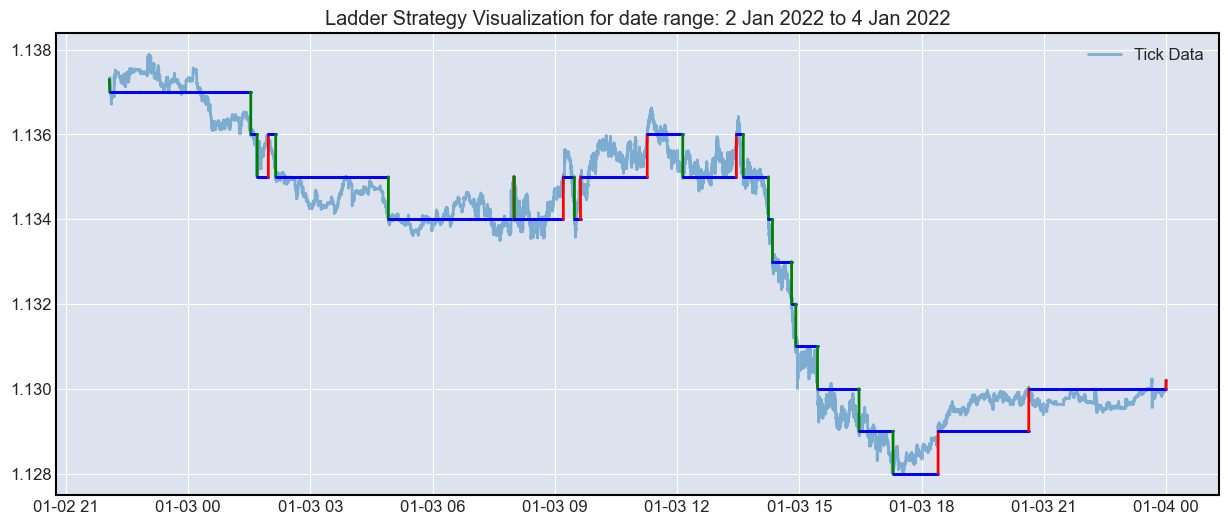

In [17]:
plot_ladderized('2 Jan 2022','4 Jan 2022',grid_size=0.001,ladderize_function=ladderize_absolute)

In [18]:
tick_data = dfb.get_tick_data('17 Aug 2023','18 Aug 2023')['EURUSD.mid']
ladderized_data = ladderize_absolute(tick_data, grid_size=0.001)

2023-09-16 20:43:28,869 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2023-09-16 20:43:28,870 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for EURUSD
2023-09-16 20:43:28,872 - findatapy.market.datavendorweb - INFO - Downloading... 2023-08-17 00:00:00 https://www.dukascopy.com/datafeed/EURUSD/2023/07/17/00h_ticks.bi5


2023-09-16 20:43:35,458 - findatapy.market.datavendorweb - INFO - Completed request from Dukascopy
2023-09-16 20:43:35,468 - findatapy.market.ioengine - WARNING - Couldn't push MarketDataRequest_858__abstract_curve_key-None__base_depos_currencies-EUR_GBP_AUD_NZD_USD_CAD_CHF_NOK_SEK_JPY__base_depos_tenor-ON_TN_SN_1W_2W_3W_1M_... to Redis: Error 61 connecting to 127.0.0.1:6379. Connection refused.


In [19]:
ladderized_data[0]

1.0875

In [20]:
def filter_jumps(ladderized_data):
    """
    Filters ladderized data to keep only the changes in price.

    :param ladderized_data: A pandas Series of ladderized data.
    :return: A pandas Series containing only the data points where there's a change.
    """
    # Calculate the difference between consecutive ladderized data points
    diff = ladderized_data.diff()

    # Filter where the difference is non-zero and include the first data point
    jumps = ladderized_data[diff != 0.0]

    return jumps


In [21]:
def aggregate_differences(jumps,lot_size=1):
    """
    Aggregate the position for buy/sell signals.

    :param jumps: A pandas Series of ladderized data filtered for jumps.
    :return: A pandas Series representing the aggregated position.
    """
    aggregated_position = [0]  # starting from 0
    position = 0
    previous_value = jumps.values[0]
    
    for value in jumps.values[1:]:
        if value > previous_value:
            position -= lot_size  # selling one lot
        else:
            position += lot_size  # buying one lot
        aggregated_position.append(position)
        previous_value = value
    aggregated_position[-1]=0 # closing the position
    return pd.Series(aggregated_position, index=jumps.index)


In [22]:
def plot_jumps(ladderized_data):
    jumps = filter_jumps(ladderized_data)
    aggregated_diff = aggregate_differences(jumps)
    fig,axs = plt.subplots(2,1,figsize=(10,10))
    # Plotting the jumps
    axs[0].plot(jumps.values, label='binomial jumps', linestyle='--', alpha=0.7)
    axs[0].set_title('ladder with jumps')
    # Adding colored points for up and down movements
    previous_value = jumps.values[0]
    for idx, value in enumerate(jumps.values[1:], 1):
        if idx == len(jumps)-1:
            continue
        elif value > previous_value:
            axs[0].plot(idx, value, 'ro')  # Red point for upward movement
        elif value < previous_value:
            axs[0].plot(idx, value, 'go')  # green point for downward movement
        else:
            axs[0].plot(idx, value, 'bo') # blue point for no change
        previous_value = value
        
        # Add vertical line to all subplots
        for ax in axs:
            ax.axvline(idx, alpha=0.5, color='gray')
            
            
    axs[0].legend()
    # Plotting the aggregated differences
    axs[1].plot(aggregated_diff.values, label='position', linestyle='-', color='purple', alpha=0.8, drawstyle='steps-post')
    axs[1].legend()
    axs[1].set_title('positions')
    plt.show()

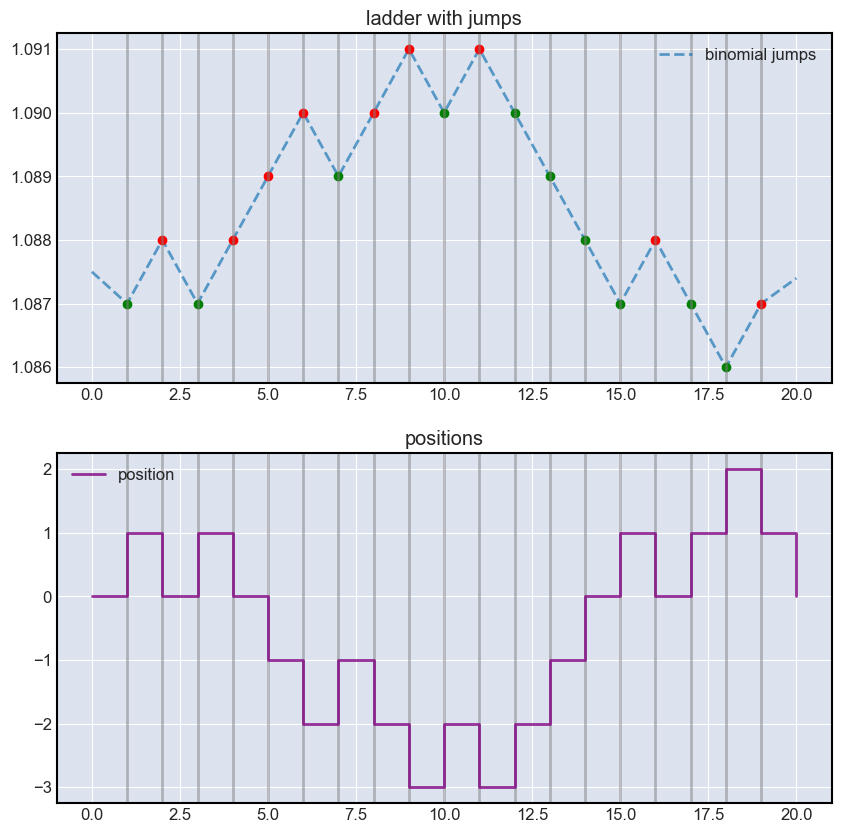

In [23]:
plot_jumps(ladderized_data)

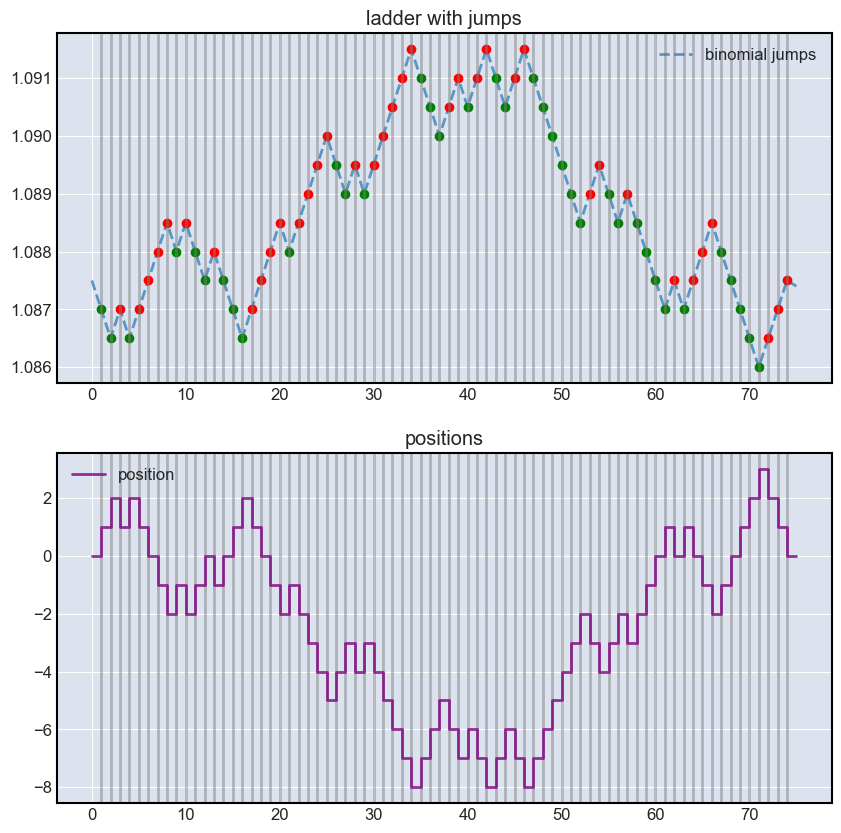

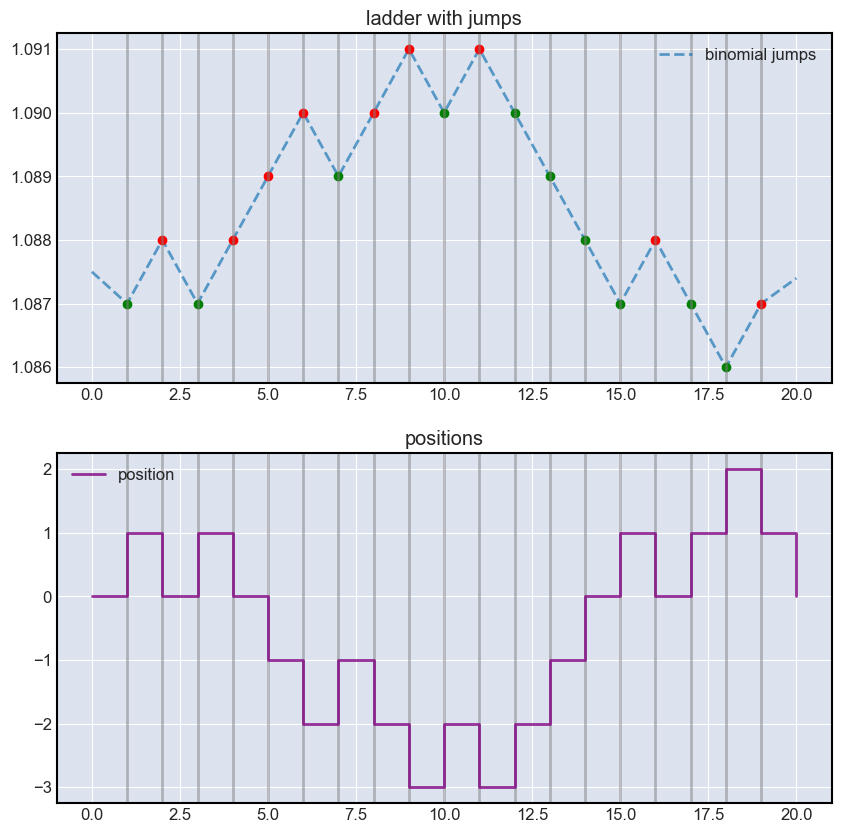

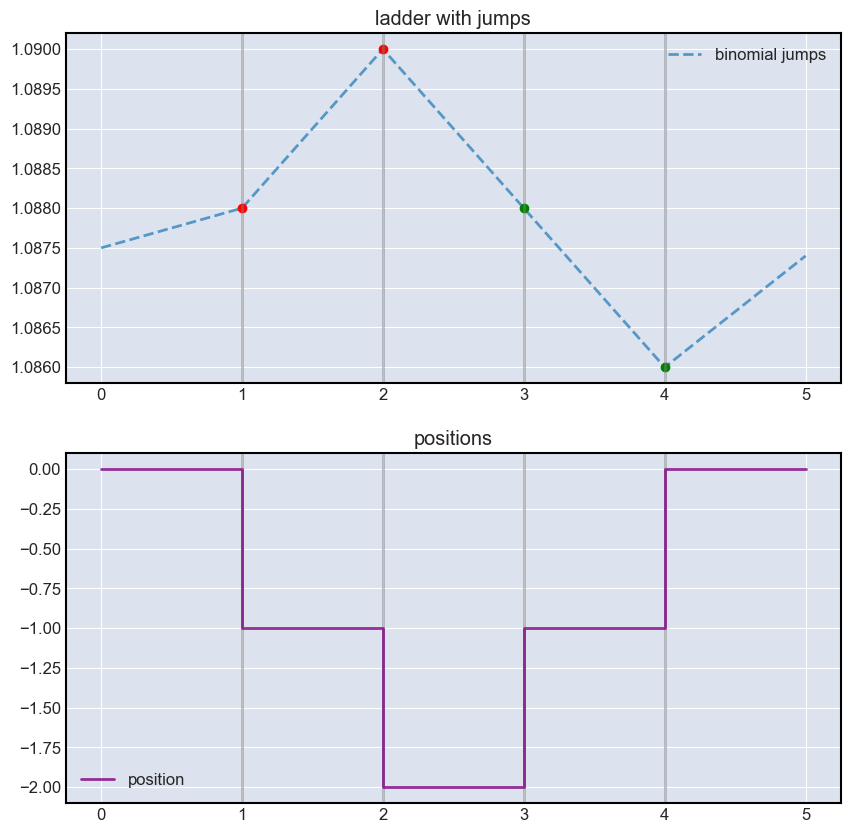

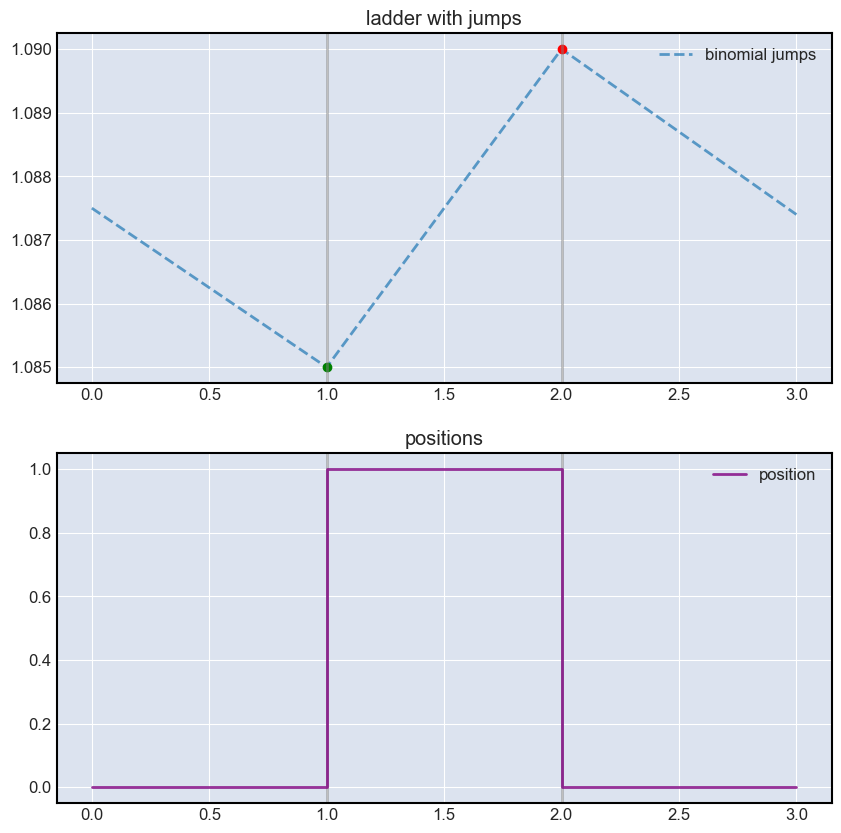

In [24]:
for grid_sizing in [0.0005, 0.001, 0.002, 0.005]:
    ladderised_data = ladderize_absolute(tick_data, grid_size=grid_sizing)
    plot_jumps(ladderised_data)

In [73]:
def velocity(data):
    #return 1000*data.diff()/(data)
    return abs(10000*data.diff()/(data))

def acceleration(data):
    #return 1000*data.diff().diff()/(data)
    return abs(10000*data.diff().diff()/(data))

In [74]:
jumps = filter_jumps(ladderized_data)
jump_ema = jumps.ewm(span=10).mean()

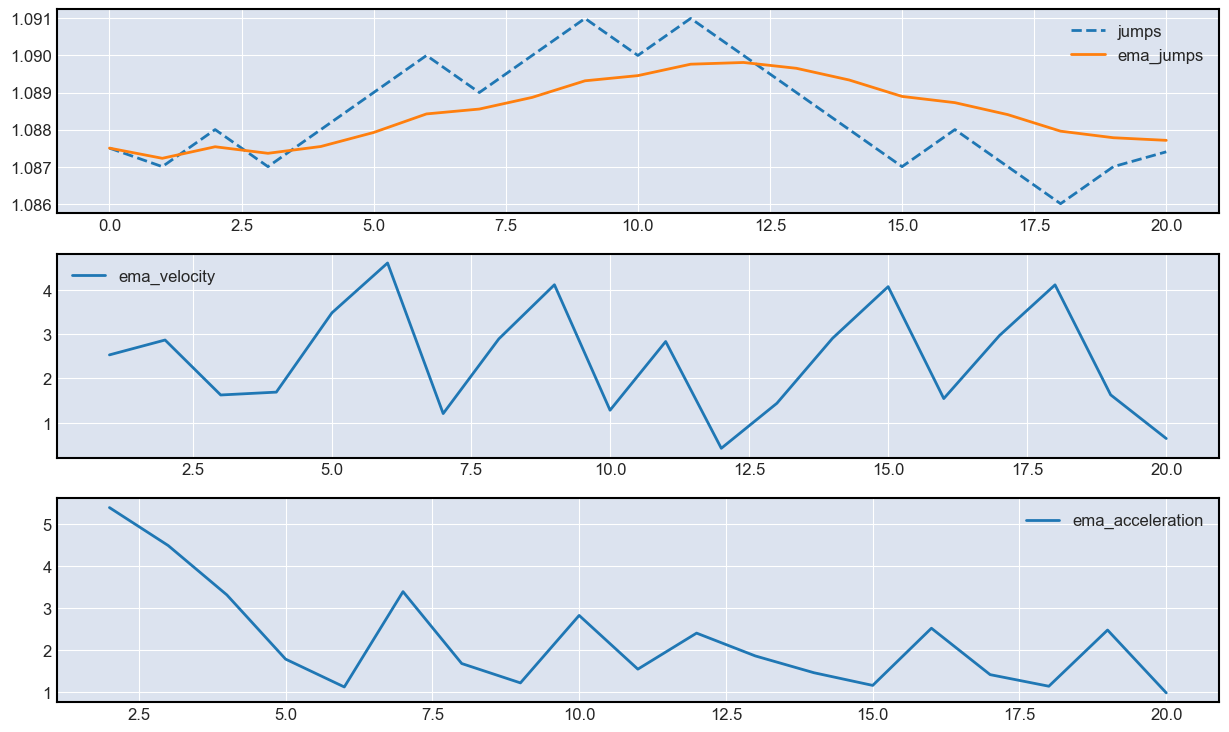

In [75]:
# Plot the results
fig,axs = plt.subplots(3,1,figsize=(15,9))
axs[0].plot(jumps.values, label='jumps', linestyle='--')
axs[0].plot(jump_ema.values, label='ema_jumps', linestyle='-')
#axs[0].plot(ladderized_data, label='Ladderized Data',alpha=0.5)
axs[0].legend()
axs[1].plot(velocity(jump_ema).values, label='ema_velocity')
axs[1].legend()
axs[2].plot(acceleration(jump_ema).values, label='ema_acceleration')
axs[2].legend()
plt.show() 

In [28]:
def convert_to_grid_binomial_data(tick_data,grid_size,ladderized_function):
    ladderized_data = ladderized_function(tick_data,grid_size)
    jumps = filter_jumps(ladderized_data)
    binomial_data = jumps.diff()
    binomial_data[1:] = np.where(binomial_data[1:] > 0,1,-1)
    binomial_data[0] = 0
    return jumps,binomial_data

In [29]:
grid_jumps,binomial_data = convert_to_grid_binomial_data(tick_data,0.0005,ladderize_absolute)

In [30]:
 for i in range(10):
     print(grid_jumps[i],binomial_data[i])

1.0875 0.0
1.087 -1.0
1.0865 -1.0
1.087 1.0
1.0865 -1.0
1.087 1.0
1.0875 1.0
1.088 1.0
1.0885 1.0
1.088 -1.0


## Strategy

In [49]:
start_date = '9 Aug 2023'
end_date = '11 Aug 2023'
tick_data = dfb.get_tick_data(start_date,end_date)['EURUSD.mid']

2023-09-16 21:14:44,222 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2023-09-16 21:14:44,222 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for EURUSD
2023-09-16 21:14:44,225 - findatapy.market.datavendorweb - INFO - Downloading... 2023-08-09 00:00:00 https://www.dukascopy.com/datafeed/EURUSD/2023/07/09/00h_ticks.bi5


2023-09-16 21:14:49,392 - findatapy.market.datavendorweb - INFO - Downloading... 2023-08-10 00:00:00 https://www.dukascopy.com/datafeed/EURUSD/2023/07/10/00h_ticks.bi5
2023-09-16 21:14:55,024 - findatapy.market.datavendorweb - INFO - Completed request from Dukascopy
2023-09-16 21:14:55,031 - findatapy.market.ioengine - WARNING - Couldn't push MarketDataRequest_858__abstract_curve_key-None__base_depos_currencies-EUR_GBP_AUD_NZD_USD_CAD_CHF_NOK_SEK_JPY__base_depos_tenor-ON_TN_SN_1W_2W_3W_1M_... to Redis: Error 61 connecting to 127.0.0.1:6379. Connection refused.


In [50]:
grid_sizing = 0.001
lot_sizing = 1000000
grid_jumps,binomial_data = convert_to_grid_binomial_data(tick_data,grid_sizing,ladderize_absolute)

In [51]:
for i in range(10):
    print(grid_jumps[i],binomial_data[i])

1.0959 0.0
1.096 1.0
1.097 1.0
1.098 1.0
1.097 -1.0
1.098 1.0
1.099 1.0
1.098 -1.0
1.099 1.0
1.098 -1.0


In [52]:
def build_lot_sizing(lot_sizing,T,multiplier=1,indicator_data=[]):
    if len(indicator_data) == 0:
        return [lot_sizing * (multiplier**i) for i in range(T)]
    else:
        return lot_sizing * indicator_data

In [58]:
jump_ema = grid_jumps.ewm(span=10).mean()
indicator_data = velocity(jump_ema)

In [59]:
def run_strategy_continuous(tick_data,grid_sizing,lot_sizing,ladder_function=ladderize_absolute,multiplier=1,indicator_data=[],print_trade_book=False):
    grid_jumps,binomial_data = convert_to_grid_binomial_data(tick_data,grid_sizing,ladder_function)
    T = len(binomial_data)
    PNL = np.zeros(T)
    P = np.zeros(T)
    N = np.zeros(T)
    trades = pd.DataFrame(columns=['t','price','Previous_lots','current_lots','position','PNL'])
    position_sizing = build_lot_sizing(lot_sizing,T,multiplier=multiplier,indicator_data=indicator_data)
    for t in np.arange(0,T):
        N[t] = N[t-1] - position_sizing[t] * binomial_data[t]
        P[t] = P[t-1] - position_sizing[t] * grid_jumps[t] * binomial_data[t]
        PNL[t] = PNL[t-1] + N[t-1] * (grid_jumps[t] - grid_jumps[t-1])
        PNL[t]=np.round(PNL[t],2)
        if print_trade_book:
            print('t = {}, price={}, Previous_lots = {},  current_lots= {},position = {},PNL = {}'.format(t,grid_jumps[t],N[t-1],N[t],P[t-1],PNL[t]))
        trade = pd.Series({'t':t,'price':grid_jumps[t],'Previous_lots':N[t-1],'current_lots':N[t],'position':P[t],'PNL':PNL[t]})
        trades = pd.concat([trades, trade.to_frame().T])
    return PNL,P,trades

In [60]:
PNL, P, trades = run_strategy_continuous(tick_data,grid_sizing,lot_sizing,ladder_function=ladderize_absolute,multiplier=1,indicator_data=indicator_data,print_trade_book=True)

t = 0, price=1.0959, Previous_lots = 0.0,  current_lots= 0.0,position = 0.0,PNL = 0.0
t = 1, price=1.096, Previous_lots = 0.0,  current_lots= -1000000.0,position = 0.0,PNL = 0.0
t = 2, price=1.097, Previous_lots = -1000000.0,  current_lots= -2000000.0,position = -1096000.0,PNL = -1000.0
t = 3, price=1.098, Previous_lots = -2000000.0,  current_lots= -3000000.0,position = -2193000.0,PNL = -3000.0
t = 4, price=1.097, Previous_lots = -3000000.0,  current_lots= -2000000.0,position = -3291000.0,PNL = 0.0
t = 5, price=1.098, Previous_lots = -2000000.0,  current_lots= -3000000.0,position = -2194000.0,PNL = -2000.0
t = 6, price=1.099, Previous_lots = -3000000.0,  current_lots= -4000000.0,position = -3292000.0,PNL = -5000.0
t = 7, price=1.098, Previous_lots = -4000000.0,  current_lots= -3000000.0,position = -4391000.0,PNL = -1000.0
t = 8, price=1.099, Previous_lots = -3000000.0,  current_lots= -4000000.0,position = -3293000.0,PNL = -4000.0
t = 9, price=1.098, Previous_lots = -4000000.0,  current

In [55]:
trades

,t,price,Previous_lots,current_lots,position,PNL
0,0.0,1.0959,0.0,0.0,0.0,0.0
0,1.0,1.0960,0.0,-1000000.0,-1096000.0,0.0
0,2.0,1.0970,-1000000.0,-2000000.0,-2193000.0,-1000.0
0,3.0,1.0980,-2000000.0,-3000000.0,-3291000.0,-3000.0
0,4.0,1.0970,-3000000.0,-2000000.0,-2194000.0,0.0
0,5.0,1.0980,-2000000.0,-3000000.0,-3292000.0,-2000.0
0,6.0,1.0990,-3000000.0,-4000000.0,-4391000.0,-5000.0
0,7.0,1.0980,-4000000.0,-3000000.0,-3293000.0,-1000.0
0,8.0,1.0990,-3000000.0,-4000000.0,-4392000.0,-4000.0
0,9.0,1.0980,-4000000.0,-3000000.0,-3294000.0,-0.0


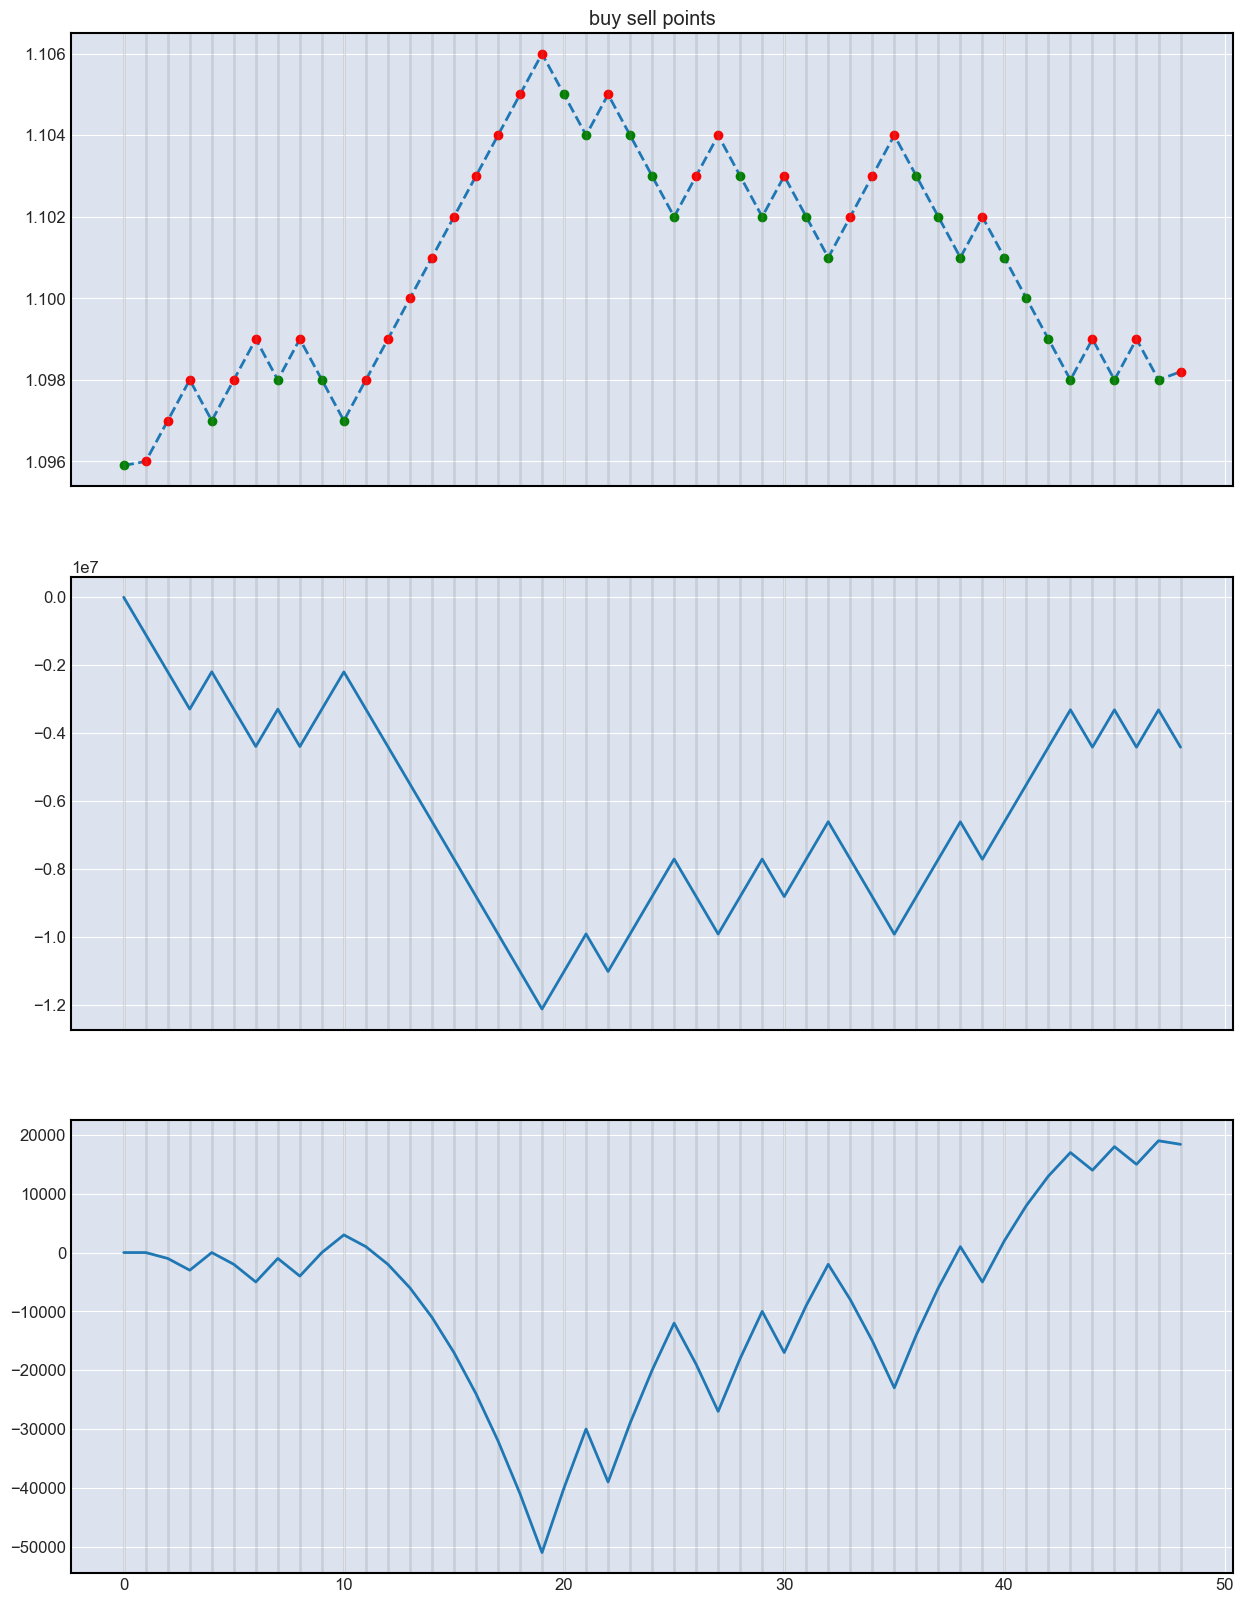

In [56]:
fig, axs = plt.subplots(3, 1, figsize=(15, 20), sharex=True)
axs[0].plot(grid_jumps.values, label='jumps', linestyle='--')

for idx, i in enumerate(grid_jumps):
    if grid_jumps[idx] > grid_jumps[idx-1]:
        axs[0].plot(idx, i, 'ro')  # Red point for upward movement
    elif grid_jumps[idx] < grid_jumps[idx-1]:
        axs[0].plot(idx, i, 'go')  # Green point for downward movement
    else:
        axs[0].plot(idx, i, 'bo')  # Blue point for no change

    # Add vertical line to all subplots
    for ax in axs:
        ax.axvline(idx, alpha=0.2, color='gray')

axs[0].set_title('buy sell points')
axs[1].plot(P)
axs[2].plot(PNL)
plt.show()


In [76]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


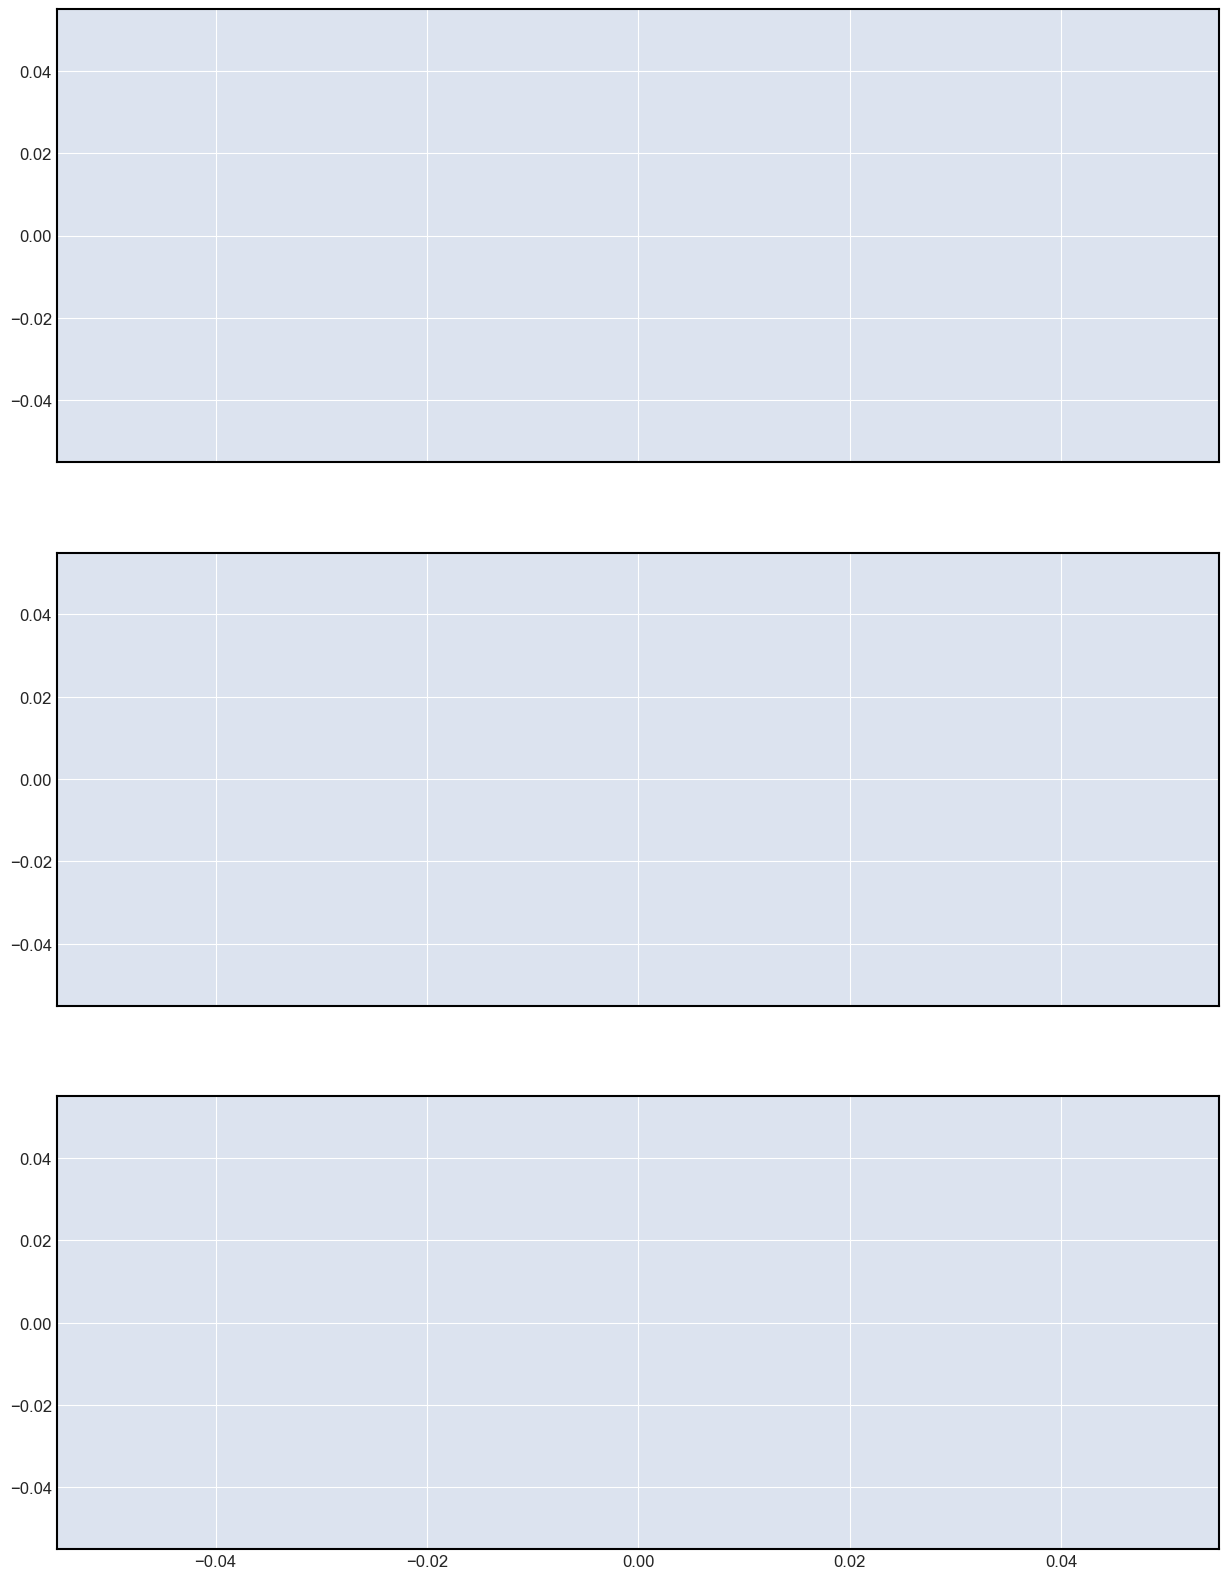

In [77]:
fig, axs = plt.subplots(3, 1, figsize=(15, 20), sharex=True)
line1, = axs[0].plot([], [], label='jumps', linestyle='--')
points_up, = axs[0].plot([], [], 'ro')
points_down, = axs[0].plot([], [], 'go')
points_same, = axs[0].plot([], [], 'bo')
line2, = axs[1].plot([], [])
line3, = axs[2].plot([], [])

def init():
    axs[0].set_xlim(0, len(grid_jumps))
    axs[0].set_ylim(min(grid_jumps) - 1, max(grid_jumps) + 1)
    axs[1].set_xlim(0, len(P))
    axs[1].set_ylim(min(P) - 1, max(P) + 1)
    axs[2].set_xlim(0, len(PNL))
    axs[2].set_ylim(min(PNL) - 1, max(PNL) + 1)
    return line1, points_up, points_down, points_same, line2, line3


In [78]:
def update(frame):
    line1.set_data(range(frame), grid_jumps[:frame])
    line2.set_data(range(frame), P[:frame])
    line3.set_data(range(frame), PNL[:frame])
    
    if frame > 0:
        if grid_jumps[frame] > grid_jumps[frame-1]:
            points_up.set_data(frame, grid_jumps[frame])
        elif grid_jumps[frame] < grid_jumps[frame-1]:
            points_down.set_data(frame, grid_jumps[frame])
        else:
            points_same.set_data(frame, grid_jumps[frame])
    
    for ax in axs:
        ax.axvline(frame, alpha=0.2, color='gray')
    
    return line1, points_up, points_down, points_same, line2, line3


In [79]:
ani = FuncAnimation(fig, update, frames=len(grid_jumps), init_func=init, blit=True)
plt.show()


In [ ]:
ani = FuncAnimation(fig, update, frames=len(grid_jumps), init_func=init, blit=True)
ani.save('animation.mp4', writer='ffmpeg', fps=1)
